# Flash-ANSR Refinement Method Benchmark
This notebook benchmarks different constant-refinement algorithms across dataset sizes. It generates synthetic symbolic-regression data, loads `FlashANSR` with the chosen refiner method, times the fit/refine pass, and visualizes scaling.

In [1]:
import os
import time
import math
import json
from pathlib import Path
from typing import Callable, Iterable, Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from simplipy import SimpliPyEngine

from flash_ansr.flash_ansr import FlashANSR, SoftmaxSamplingConfig
from flash_ansr.utils.paths import substitute_root_path

# Resolve repository root by walking up to find pyproject
_ROOT_CANDIDATE = Path.cwd().resolve()
for candidate in [_ROOT_CANDIDATE, *_ROOT_CANDIDATE.parents]:
    if (candidate / "pyproject.toml").exists():
        ROOT = candidate
        break
else:
    ROOT = _ROOT_CANDIDATE

if str(ROOT) not in os.sys.path:
    os.sys.path.insert(0, str(ROOT))

# Model directory placeholder; update to a cached checkpoint to avoid downloads.
MODEL_DIR = substitute_root_path(str(ROOT / "models/ansr-models/v23.0-120M"))
if not Path(MODEL_DIR).exists():
    raise FileNotFoundError(f"Model directory not found: {MODEL_DIR}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device={DEVICE}")

# Available refiner methods in this repo
REFINER_METHODS: list[str] = [
    "torch_adam",
    "torch_lbfgs",
    "curve_fit_lm",
    "minimize_lbfgsb",
]

# Method-specific optimizer kwargs (torch gets stronger defaults)
REFINER_OPT_KW: dict[str, dict] = {
    "torch_adam": {
        "lr": 5e-2,
        "steps": 1000,
        "batch_size": 256,
        "device": DEVICE,
    },
    "torch_lbfgs": {
        "lr": 1e-1,
        "max_iter": 400,
        "history_size": 20,
        "device": DEVICE,
    },
}

# Dataset sizes to probe
DATASET_SIZES = [10, 100, 1_000, 10_000, 100_000, 1_000_000]

Using device=cuda


In [2]:
def make_synthetic_data(n: int, noise: float = 0.01) -> tuple[np.ndarray, np.ndarray, list[str]]:
    """Generate synthetic data for y = sin(x1) + 0.5 * x2^2 + 3.

    Returns
    -------
    X : (n, 2) float array
    y : (n, 1) float array
    expr : prefix tokens representing the ground-truth expression
    """
    rng = np.random.default_rng(0)
    x1 = rng.uniform(-2 * math.pi, 2 * math.pi, size=n)
    x2 = rng.uniform(-2.0, 2.0, size=n)
    y = np.sin(x1) + 0.5 * (x2 ** 2) + 3.0
    if noise > 0:
        y = y + rng.normal(scale=noise, size=n)
    X = np.stack([x1, x2], axis=-1).astype(np.float32)
    y = y.astype(np.float32).reshape(-1, 1)
    expr = ["+", "+", "sin", "x1", "*", "0.5", "x2", "x2", "3"]
    return X, y, expr


def build_flash_ansr(method: str) -> FlashANSR:
    """Load FlashANSR with a specific refiner method.

    Note: loading once per method keeps refiner config clean; model weights are shared.
    """
    optimizer_kwargs = REFINER_OPT_KW.get(method, {})
    model = FlashANSR.load(
        directory=str(MODEL_DIR),
        device=DEVICE,
        generation_config=SoftmaxSamplingConfig(choices=32, batch_size=1),
        n_restarts=8,
        refiner_method=method,
        refiner_p0_noise="normal",
        refiner_p0_noise_kwargs={"loc": 0.0, "scale": 1.0},
        refiner_optimizer_kwargs=optimizer_kwargs,
        numpy_errors="ignore",
        refiner_workers=0,
    )
    return model


def run_fit_timing(model: FlashANSR, X: np.ndarray, y: np.ndarray) -> float:
    """Time end-to-end FlashANSR.fit (generation + refinement)."""
    start = time.perf_counter()
    model.fit(X=X, y=y, converge_error="ignore", verbose=True)
    return float(time.perf_counter() - start)

In [ ]:
def benchmark(methods: Iterable[str], sizes: Iterable[int]) -> pd.DataFrame:
    rows = []
    models: dict[str, FlashANSR] = {}

    for method in methods:
        print(f"Loading model for method={method} ...")
        models[method] = build_flash_ansr(method)

    for method, model in models.items():
        for n in sizes:
            X, y, _expr = make_synthetic_data(n)
            X = X[:, : model.n_variables]
            try:
                elapsed = run_fit_timing(model, X, y)
            except Exception as exc:  # noqa: BLE001
                print(f"Method {method} failed at n={n}: {exc}")
                elapsed = math.nan
            rows.append({"method": method, "n": n, "seconds": elapsed})
            print(f"method={method} n={n} -> {elapsed:.4f} s")

    return pd.DataFrame(rows)


results = benchmark(REFINER_METHODS, DATASET_SIZES)
results

Loading model for method=torch_adam ...
Loading model for method=torch_lbfgs ...
Loading model for method=torch_lbfgs ...
Loading model for method=curve_fit_lm ...
Loading model for method=curve_fit_lm ...
Loading model for method=minimize_lbfgsb ...
Loading model for method=minimize_lbfgsb ...


Loading model for method=torch_adam ...
Loading model for method=torch_lbfgs ...
Loading model for method=torch_lbfgs ...
Loading model for method=curve_fit_lm ...
Loading model for method=curve_fit_lm ...
Loading model for method=minimize_lbfgsb ...
Loading model for method=minimize_lbfgsb ...


Fitting Constants:   0%|          | 0/6 [00:00<?, ?it/s]

Loading model for method=torch_adam ...
Loading model for method=torch_lbfgs ...
Loading model for method=torch_lbfgs ...
Loading model for method=curve_fit_lm ...
Loading model for method=curve_fit_lm ...
Loading model for method=minimize_lbfgsb ...
Loading model for method=minimize_lbfgsb ...


Fitting Constants:   0%|          | 0/6 [00:00<?, ?it/s]

Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps


Loading model for method=torch_adam ...
Loading model for method=torch_lbfgs ...
Loading model for method=torch_lbfgs ...
Loading model for method=curve_fit_lm ...
Loading model for method=curve_fit_lm ...
Loading model for method=minimize_lbfgsb ...
Loading model for method=minimize_lbfgsb ...


Fitting Constants:   0%|          | 0/6 [00:00<?, ?it/s]

Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps


Fitting Constants:  17%|█▋        | 1/6 [00:00<00:01,  3.12it/s]


Loading model for method=torch_adam ...
Loading model for method=torch_lbfgs ...
Loading model for method=torch_lbfgs ...
Loading model for method=curve_fit_lm ...
Loading model for method=curve_fit_lm ...
Loading model for method=minimize_lbfgsb ...
Loading model for method=minimize_lbfgsb ...


Fitting Constants:   0%|          | 0/6 [00:00<?, ?it/s]

Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps


Fitting Constants:  17%|█▋        | 1/6 [00:00<00:01,  3.12it/s]


Starting optimization...
Optimizing...
Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps
Starting optimization...
Optimizing...
Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps
Starting optimization...
Optimizing...
Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps
Starting optimization...
Optimizing...
Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps
Starting optimization...
Optimizing...
Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps
Starting optimization...
Optimizing...
Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps
Starting optimization...
Optimizing...
Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps
Starting optimization...
Optimizing...
Running torch optimizer 'torch_adam' on device 'cpu' for 500 steps
Starting optimization...
Optimizing...
Method torch_adam failed at n=10: cannot access local variable 'torch' where it is not associated with a value
me

Generating tokens:  23%|██▎       | 14/62 [00:03<00:12,  3.69it/s]

In [ ]:
# Persist results
out_dir = Path.cwd()
results_path = out_dir / "refiner_benchmark_results.csv"
json_path = out_dir / "refiner_benchmark_results.json"
results.to_csv(results_path, index=False)
results.to_json(json_path, orient="records", indent=2)
results_path, json_path

(PosixPath('/home/psaegert/Projects/flash-ansr/experimental/refiner_benchmark_results.csv'),
 PosixPath('/home/psaegert/Projects/flash-ansr/experimental/refiner_benchmark_results.json'))

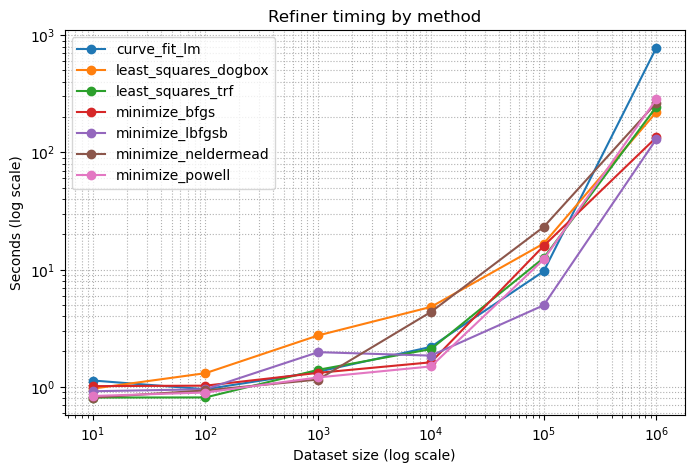

In [ ]:
# Visualize scaling
plt.figure(figsize=(8, 5))
for method, df_method in results.groupby("method"):
    plt.plot(df_method["n"], df_method["seconds"], marker="o", label=method)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Dataset size (log scale)")
plt.ylabel("Seconds (log scale)")
plt.title("Refiner timing by method")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.show()


In [ ]:
# Sanity checks
assert set(results.columns) == {"method", "n", "seconds"}
assert set(results["method"]) == set(REFINER_METHODS)
assert set(results["n"]) == set(DATASET_SIZES)
print("Recorded entries:", len(results))

Recorded entries: 35
